# How consistently are areas ranked?

For each month, compute the ranking of each area in terms of ASB incidents (with smoothing) and measure temporal consistency (somehow)


In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
from collections import defaultdict
from itertools import pairwise

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    Force,
    calc_gini,
    cosine_similarity,
    extract_crime_data,
    lorenz_curve,
    rank_biased_overlap,
    spearman_rank_correlation,
    spearman_rank_correlation_matrix,
    tokenize_force_name,
)

## Set parameters and fetch crime data

Spatial unit comparison (census geographies control for resident population and can vary widely in area)

Unit | Size/resolution | Mean area (km²)*
-----|-----------------|----------
MSOA |                 | 6.7
HEX  | 7               | 4.6
LSOA |                 | 1.4
GRID | 1000m           | 1.0
HEX  | 8               | 0.65
OA   |                 | 0.28
GRID | 500m            | 0.25
GRID | 200m            | 0.04
HEX  | 9               | 0.093

&ast; over West Yorkshire force area

In [10]:
FORCE: Force = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
OBSERVATION_WINDOW = 3  # months
AREA: SpatialUnit = "STREET"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "FE"},
        "GRID": {"size": 500.0},
        "HEX": {"resolution": 8},
    },
)
SAMPLE_FRACTION = 0.5

In [11]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(tokenize_force_name(FORCE))
# filter by category and remove any points
raw_crime_data = raw_crime_data[raw_crime_data["Crime type"] == CATEGORY]
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
timespan = len(raw_crime_data.Month.unique()) / 12
raw_crime_data

Month            Reported by           Falls within  \
Crime ID                                                          
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
...           ...                    ...                    ...   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type                       geometry  
Crime ID                                                        
NaN       Anti-social behaviour  POINT (411354.013 447133.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour   POINT (411758.03 447302.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour  POINT (412391.978 447481.039)  
...                         ...                            ...  
NaN       Anti-social behaviour  POINT (446750.007 410878.044)  
NaN       Anti-social behaviour  POINT (446414.024 410431.008)  
NaN       Anti-social behaviour  POINT (446666.975 410800.005)  
NaN       Anti-social behaviour   POINT (444840.023 410291.97)  
NaN       Anti-social behaviour  POINT (444982.991 411990.995)  

[81698 rows x 8 columns]

## Get spatial data

Assign crimes to spatial units requested for later aggregation

In [12]:
crime_data, spatial_units = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])
crime_data

Month            Reported by           Falls within  \
Crime ID                                                          
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
...           ...                    ...                    ...   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type                       geometry  \
Crime ID                                                         
NaN       Anti-social behaviour  POINT (411354.013 447133.948)   
NaN       Anti-social behaviour  POINT (411854.969 447613.948)   
NaN       Anti-social behaviour   POINT (411758.03 447302.948)   
NaN       Anti-social behaviour  POINT (411854.969 447613.948)   
NaN       Anti-social behaviour  POINT (412391.978 447481.039)   
...                         ...                            ...   
NaN       Anti-social behaviour  POINT (446750.007 410878.044)   
NaN       Anti-social behaviour  POINT (446414.024 410431.008)   
NaN       Anti-social behaviour  POINT (446666.975 410800.005)   
NaN       Anti-social behaviour   POINT (444840.023 410291.97)   
NaN       Anti-social behaviour  POINT (444982.991 411990.995)   

                          spatial_unit    distance  
Crime ID                                            
NaN       (12843840683, 1336722281, 0)    0.981018  
NaN            (28141941, 28141947, 0)   19.483412  
NaN            (24556540, 24556624, 0)    1.545469  
NaN            (28141941, 28141947, 0)   19.483412  
NaN           (20940863, 676654317, 0)    0.843365  
...                                ...         ...  
NaN          (853543211, 853543210, 0)    0.513230  
NaN        (662951565, 11227573808, 0)    1.741161  
NaN          (853543232, 853543210, 0)    1.622820  
NaN          (861301782, 861302217, 0)    0.308565  
NaN       (6455532392, 12752999665, 0)  147.824679  

[81698 rows x 10 columns]

In [10]:
# optionally explore discrepancies between reported point and reported LSOA
if AREA == "LSOA":
    mismatches = crime_data[crime_data["spatial_unit"] != crime_data["LSOA code"]][
        ["spatial_unit", "LSOA21NM", "LSOA code", "LSOA name", "geometry"]
    ]  # should be true if LSOA code is set correctly
    mismatches["reported_geometry"] = mismatches["LSOA code"].map(spatial_units.geometry)
    distances = mismatches.geometry.distance(mismatches.reported_geometry)
    display(
        f"Total mismatches {len(mismatches)} of which {mismatches.reported_geometry.isna().sum()} are inactive LSOAs"
    )
    display(f"Point-reported geometry discrepancy distance mean={distances.mean():.1f}m max={distances.max():.1f}m")

'Total mismatches 3663 of which 1021 are inactive LSOAs'

'Point-reported geometry discrepancy distance mean=0.2m max=13.2m'

## Compute counts and rates

Display rates for each area on a map (too many street segments to render)

In [13]:
# ensure we account for crime-free spatial units in the data
counts = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .sort_index()
)
# num_areas = len(crime_data.area.unique())
smoothed_counts = counts.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
smoothed_counts

Month                           2022-07   2022-08   2022-09   2022-10  \
spatial_unit                                                            
(318837, 270591425, 0)         0.000000  1.000000  1.000000  1.000000   
(321632, 321645, 0)            0.000000  0.000000  0.000000  0.000000   
(321692, 344764167, 0)         0.333333  0.333333  0.000000  0.000000   
(321759, 614241872, 0)         0.333333  0.333333  0.333333  0.666667   
(321854, 247782201, 0)         1.333333  2.666667  2.666667  1.666667   
...                                 ...       ...       ...       ...   
(12840668914, 263708202, 0)    0.333333  0.333333  0.333333  0.666667   
(12840668980, 12467726967, 0)  0.333333  0.666667  0.666667  0.666667   
(12843840683, 1336722281, 0)   0.333333  0.000000  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  0.000000  0.000000   
(12889120735, 983507402, 0)    0.333333  0.333333  0.000000  0.000000   

Month                           2022-11   2022-12   2023-01   2023-02  \
spatial_unit                                                            
(318837, 270591425, 0)         0.000000  0.000000  0.000000  0.000000   
(321632, 321645, 0)            0.000000  0.000000  0.000000  0.000000   
(321692, 344764167, 0)         0.000000  0.000000  0.000000  0.000000   
(321759, 614241872, 0)         0.666667  0.666667  0.333333  1.333333   
(321854, 247782201, 0)         0.333333  0.666667  1.000000  1.000000   
...                                 ...       ...       ...       ...   
(12840668914, 263708202, 0)    0.333333  0.333333  0.000000  0.000000   
(12840668980, 12467726967, 0)  0.333333  0.333333  0.000000  0.333333   
(12843840683, 1336722281, 0)   0.000000  0.000000  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  0.000000  0.000000   
(12889120735, 983507402, 0)    0.000000  0.000000  0.000000  0.000000   

Month                           2023-03   2023-04  ...   2024-07   2024-08  \
spatial_unit                                       ...                       
(318837, 270591425, 0)         0.000000  0.000000  ...  0.000000  0.000000   
(321632, 321645, 0)            0.000000  0.000000  ...  0.000000  0.000000   
(321692, 344764167, 0)         0.000000  0.000000  ...  0.000000  0.000000   
(321759, 614241872, 0)         1.333333  1.000000  ...  0.333333  0.333333   
(321854, 247782201, 0)         1.333333  0.666667  ...  0.666667  1.000000   
...                                 ...       ...  ...       ...       ...   
(12840668914, 263708202, 0)    0.000000  0.333333  ...  0.333333  0.333333   
(12840668980, 12467726967, 0)  0.333333  0.333333  ...  0.000000  0.000000   
(12843840683, 1336722281, 0)   0.000000  0.000000  ...  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  ...  0.333333  0.000000   
(12889120735, 983507402, 0)    0.000000  0.000000  ...  0.000000  0.000000   

Month                           2024-09   2024-10   2024-11   2024-12  \
spatial_unit                                                            
(318837, 270591425, 0)         0.000000  0.666667  0.666667  1.000000   
(321632, 321645, 0)            0.000000  0.000000  0.333333  0.333333   
(321692, 344764167, 0)         0.000000  0.000000  0.000000  0.000000   
(321759, 614241872, 0)         0.000000  0.000000  0.333333  0.333333   
(321854, 247782201, 0)         0.666667  0.333333  0.000000  0.000000   
...                                 ...       ...       ...       ...   
(12840668914, 263708202, 0)    0.333333  0.000000  0.333333  0.666667   
(12840668980, 12467726967, 0)  0.000000  0.000000  0.000000  0.000000   
(12843840683, 1336722281, 0)   0.000000  0.000000  0.000000  0.000000   
(12848422868, 27415046, 0)     0.000000  0.000000  0.000000  0.333333   
(12889120735, 983507402, 0)    0.000000  0.000000  0.000000  0.000000   

Month                           2025-01   2025-02   2025-03  2025-04  
spatial_unit                                                    

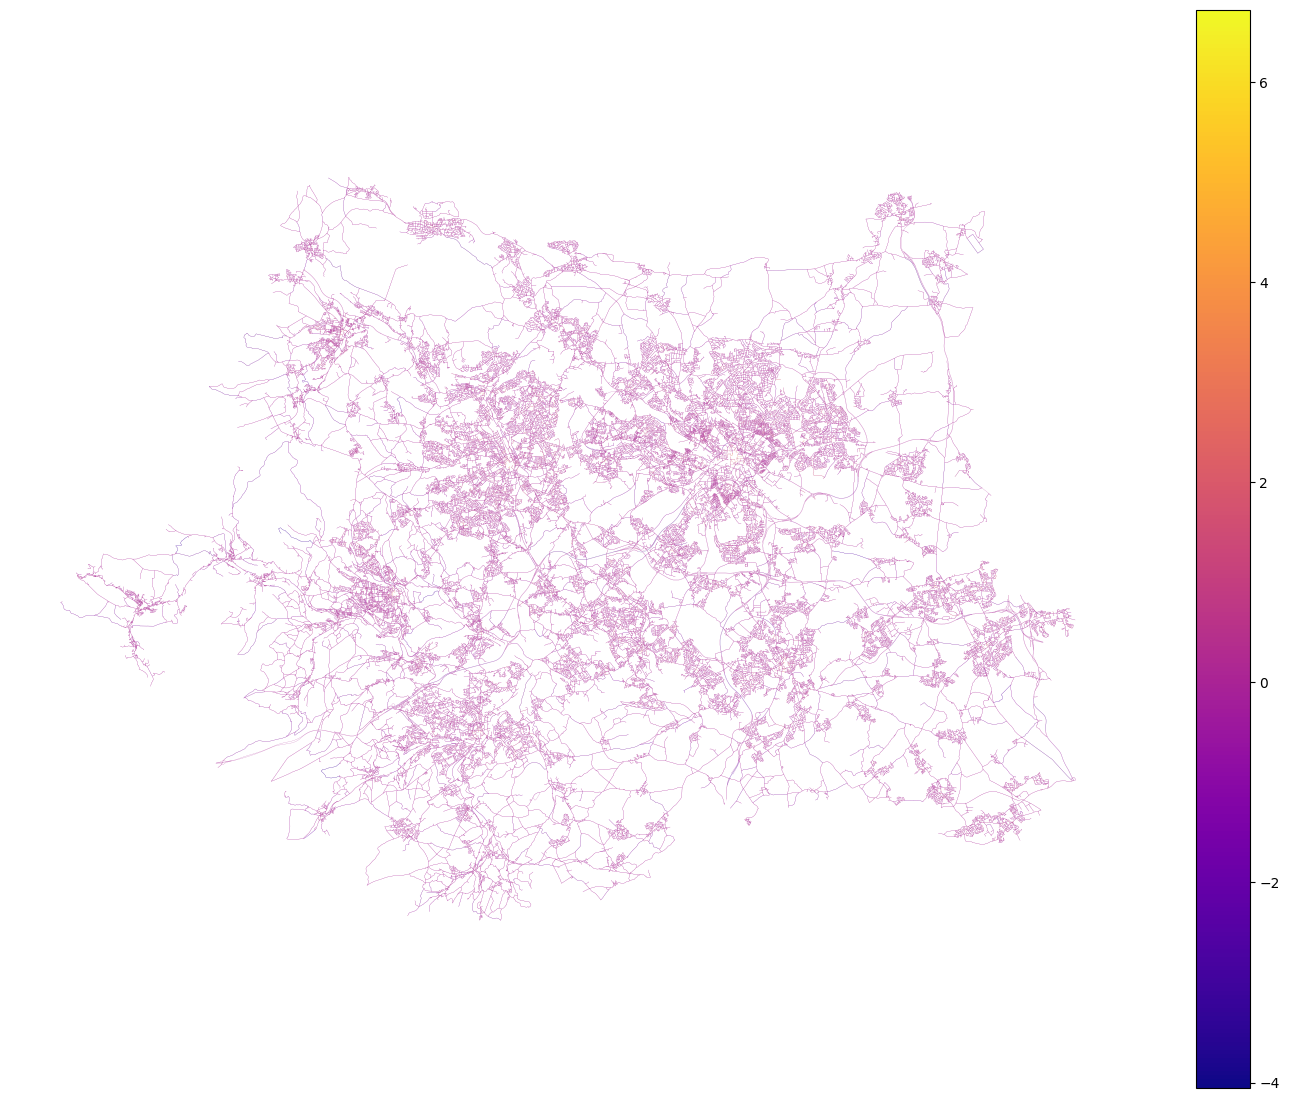

In [ ]:
# compute rates
if AREA == "STREET":
    # proxy area as length * a width factor thats consistent with the force area
    width_factor = force_boundary.area.sum() / spatial_units.length.sum()
    areas = counts.index.map(spatial_units.length) * width_factor
else:
    areas = counts.index.map(spatial_units.area)

rates = counts.div(areas, axis=0) / timespan * 1_000_000  # crimes/sq.km/year
smoothed_rates = rates.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
# smoothed_rates
rates.index = pd.MultiIndex.from_tuples(rates.index, names=["u", "v", "key"])

ax = (
    spatial_units.join(np.log(rates.mean(axis=1)).rename("mean_rate"))
    .fillna(0)
    .plot(column="mean_rate", linewidth=0.1, legend=True, figsize=(18, 14), cmap="turbo")
)
# ax = spatial_units.plot(legend=True, figsize=(18, 14))
ax.set_axis_off()

In [47]:
if AREA == "STREET":
    map = None
else:
    map = (
        spatial_units.join(rates.sum(axis=1).rename("rate"))
        .fillna(0)
        .explore(
            "rate",
            cmap="Reds",
            tiles="CartoDB positron",
            style_kwds=dict(color="black", weight=0.5, opacity=0.2, fillOpacity=0.7),
        )
    )
# force_boundary.explore(m=map, style_kwds=dict(color="black", weight=0.5, opacity=0.2, fillOpacity=0.0))
# map

/tmp/ipykernel_25394/1692452123.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)


Month     2022-05   2022-06   2022-07   2022-08   2022-09   2022-10   2022-11  \
Month                                                                           
2022-05  1.000000  0.750023  0.701241  0.705807  0.752327  0.736345  0.739291   
2022-06  0.750023  1.000000  0.708362  0.700064  0.717673  0.719763  0.707216   
2022-07  0.701241  0.708362  1.000000  0.714890  0.712191  0.699054  0.682638   
2022-08  0.705807  0.700064  0.714890  1.000000  0.718937  0.720626  0.709538   
2022-09  0.752327  0.717673  0.712191  0.718937  1.000000  0.758077  0.752758   
2022-10  0.736345  0.719763  0.699054  0.720626  0.758077  1.000000  0.761177   
2022-11  0.739291  0.707216  0.682638  0.709538  0.752758  0.761177  1.000000   
2022-12  0.688647  0.635421  0.601504  0.617377  0.712380  0.712605  0.794041   
2023-01  0.727372  0.674407  0.636472  0.672754  0.730645  0.745402  0.798620   
2023-02  0.728785  0.690755  0.667050  0.678131  0.738450  0.754043  0.773413   
2023-03  0.708990  0.687091  0.674889  0.682545  0.727037  0.748054  0.760843   
2023-04  0.682981  0.667635  0.656856  0.693343  0.720447  0.716856  0.733318   
2023-05  0.712801  0.687394  0.674802  0.702478  0.716962  0.702777  0.701959   
2023-06  0.685092  0.664437  0.681955  0.701659  0.718730  0.708347  0.732017   
2023-07  0.685502  0.667820  0.678904  0.677523  0.718127  0.701510  0.707739   
2023-08  0.681308  0.684151  0.675775  0.688462  0.719742  0.718738  0.709759   
2023-09  0.713411  0.701272  0.696328  0.698578  0.734011  0.726859  0.725354   
2023-10  0.708982  0.705081  0.677248  0.707268  0.722084  0.757308  0.737175   
2023-11  0.725503  0.700071  0.690876  0.700124  0.757193  0.756310  0.782960   
2023-12  0.713291  0.654584  0.622333  0.637420  0.716830  0.731604  0.795046   
2024-01  0.706160  0.661780  0.631195  0.648247  0.734732  0.722706  0.774514   
2024-02  0.722369  0.674668  0.664985  0.673101  0.735374  0.742224  0.763993   
2024-03  0.706061  0.686072  0.662862  0.685133  0.701191  0.709355  0.750035   
2024-04  0.699580  0.668154  0.655168  0.675560  0.711048  0.707227  0.736419   
2024-05  0.670018  0.655447  0.659188  0.662991  0.680609  0.684401  0.683101   
2024-06  0.673734  0.663493  0.649925  0.674477  0.687317  0.657685  0.684143   
2024-07  0.682575  0.653233  0.665003  0.662450  0.695597  0.683172  0.684340   
2024-08  0.665320  0.660440  0.684299  0.679153  0.704406  0.672851  0.697581   
2024-09  0.706904  0.694721  0.683390  0.675404  0.731066  0.718728  0.753417   
2024-10  0.672259  0.665523  0.660566  0.659679  0.691882  0.699371  0.732089   
2024-11  0.701108  0.691624  0.680050  0.667767  0.715195  0.729827  0.741504   
2024-12  0.695821  0.661727  0.631332  0.634169  0.719220  0.718067  0.781212   
2025-01  0.686824  0.649524  0.652445  0.637343  0.717845  0.728279  0.782642   
2025-02  0.707941  0.654111  0.633807  0.634437  0.720401  0.731419  0.787916   
2025-03  0.687173  0.650020  0.669296  0.660820  0.724198  0.707104  0.717094   
2025-04  0.632910  0.642736  0.642902  0.636957  0.649408  0.647299  0.675821   

Month     2022-12   2023-01   2023-02  ...   2024-07   2024-08   2024-09  \
Month                                  ...                                 
2022-05  0.688647  0.727372  0.728785  ...  0.682575  0.665320  0.706904   
2022-06  0.635421  0.674407  0.690755  ...  0.653233  0.660440  0.694721   
2022-07  0.601504  0.636472  0.667050  ...  0.665003  0.684299  0.683390   
2022-08  0.617377  0.672754  0.678131  ...  0.662450  0.679153  0.675404   
2022-09  0.712380  0.730645  0.738450  ...  0.695597  0.704406  0.731066   
2022-10  0.712605  0.745402  0.754043  ...  0.683172  0.672851  0.718728   
2022-11  0.794041  0.798620  0.773413  ...  0.684340  0.697581  0.753417   
2022-12  1.000000  0.837812  0.791823  ...  0.634901  0.620723  0.730285   
2023-01  0.837812  1.000000  0.801785  ...  0.683499  0.658238  0.746219   
2023-02  0.791823  0.801785  1.000000  ...  0.676086  0.654060  0.745074   
2023-03  

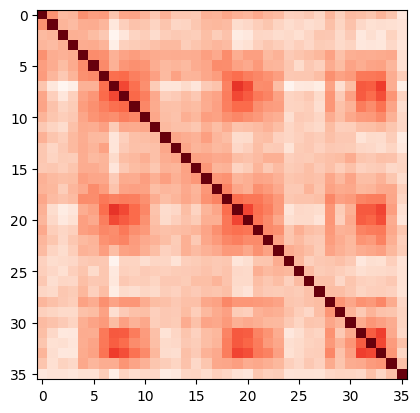

In [49]:
# rank correlation based on rates
n = len(rates.columns)
correlations = spearman_rank_correlation_matrix(rates)
cdf = pd.DataFrame(index=rates.columns, data=correlations, columns=rates.columns)
plt.imshow(cdf, cmap="Reds")
cdf

Month         2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  2023-01  \
spatial_unit                                                                  
E01033010         1.0      1.0      3.0      1.0      1.0      1.0      1.0   
E01034582        37.0     27.5     14.5      4.0      3.5      3.0      2.0   
E01033011         9.0      5.5      5.0      6.0      6.0      5.0      3.0   
E01033690         2.0      3.0      2.0      2.0      2.0      4.0      4.0   
E01034264        18.0     20.5     19.5     15.5     16.0     13.0      7.5   
...               ...      ...      ...      ...      ...      ...      ...   
E01033901      1023.0    900.5   1032.5    989.0   1309.0   1283.5   1253.0   
E01034268       571.0    760.0    881.5   1166.0   1309.0   1283.5   1253.0   
E01011054       389.5    225.5    512.5    473.5    899.0    795.0    202.0   
E01010576      1342.5   1227.0   1199.5    824.5    717.5    590.5    952.5   
E01035045      1342.5   1227.0   1199.5    989.0    899.0    590.5    696.0   

Month         2023-02  2023-03  2023-04  ...  2024-07  2024-08  2024-09  \
spatial_unit                             ...                              
E01033010         1.0      1.0      1.0  ...      1.0      1.0      1.0   
E01034582         3.0      5.0      5.0  ...      3.5      4.0      7.0   
E01033011         2.0      2.0      2.0  ...     12.0      6.0      6.0   
E01033690         4.0      3.0      3.0  ...      3.5      7.0      8.0   
E01034264        12.5     19.0     83.5  ...     33.5     40.5     24.5   
...               ...      ...      ...  ...      ...      ...      ...   
E01033901      1256.0   1281.5   1311.5  ...    895.5    739.5    998.5   
E01034268      1256.0   1281.5    869.0  ...   1210.0   1206.0    998.5   
E01011054       201.0    258.5    681.5  ...    895.5    883.5    998.5   
E01010576      1256.0   1281.5   1098.5  ...    621.5    739.5    678.5   
E01035045       946.0   1017.0   1098.5  ...   1347.5   1345.0   1338.5   

Month         2024-10  2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  
spatial_unit                                                                 
E01033010         1.0      1.0      1.0      1.0      1.0      1.0      1.0  
E01034582         5.0      2.0      2.0      2.0      2.0      2.0      2.0  
E01033011         2.0      3.0      3.0      5.0      6.0      4.5      3.5  
E01033690         7.0      6.0      5.0      3.0      3.0      3.0      3.5  
E01034264        21.5     22.5     16.5      7.0      5.0      4.5      5.0  
...               ...      ...      ...      ...      ...      ...      ...  
E01033901       669.5    932.5    894.5   1297.5   1253.5   1285.0   1319.5  
E01034268       978.5    748.5    894.5   1043.0   1253.5   1285.0   1319.5  
E01011054       537.0    477.5    411.0    783.0   1253.5   1285.0   1319.5  
E01010576       813.0   1144.5   1130.0   1297.5   1253.5   1285.0   1319.5  
E01035045      1163.0   1144.5   1130.0   1297.5   1253.5   1285.0   1319.5  

[1404 rows x 34 columns]

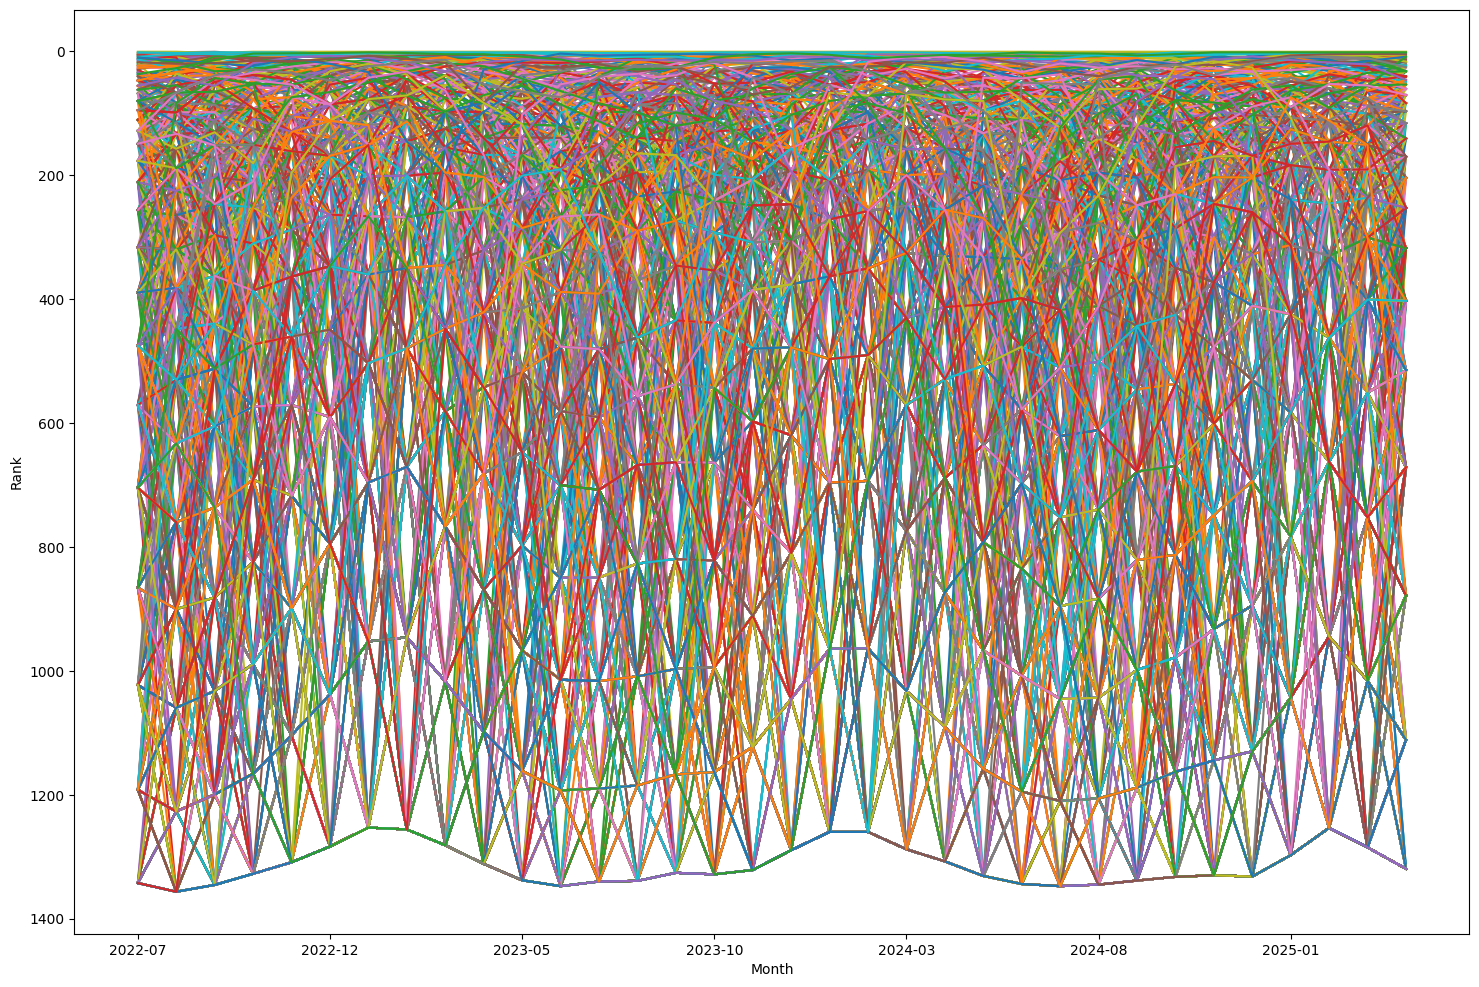

In [62]:
# ranks based on counts (default method "average" treats 2 tied at 3rd place as 3.5)
count_ranks = smoothed_counts.apply(lambda col: col.rank(ascending=False))

ax = count_ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

count_ranks.sort_values(by=count_ranks.columns[-1])

Month         2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  2023-01  \
spatial_unit                                                                  
E01033010        16.0     18.0     19.0     12.0      5.0      3.0      2.0   
E01033011         9.0      6.0      3.0      4.0      4.0      2.0      1.0   
E01010851        12.0     17.0     38.0    110.0    109.0     52.0     54.0   
E01033690         8.0      7.0      5.0      3.0      3.0      4.0      3.0   
E01011323       305.0    195.0    319.0    396.0    312.0    259.0    189.0   
...               ...      ...      ...      ...      ...      ...      ...   
E01010808        74.0    115.0    313.0    685.0    335.0    510.0    426.0   
E01011629       510.0    439.0    339.0    502.0    310.0    480.0    385.0   
E01011258      1281.0   1309.0   1287.0   1251.0   1214.0   1163.0   1102.0   
E01010593      1039.0    901.0    896.0    869.0   1214.0   1163.0    847.0   
E01011082       405.0    436.0    418.0    388.0     71.0     34.0     23.0   

Month         2023-02  2023-03  2023-04  ...  2024-07  2024-08  2024-09  \
spatial_unit                             ...                              
E01033010         2.0      2.0      2.0  ...      4.0      4.0      5.0   
E01033011         1.0      1.0      1.0  ...      7.0      1.0      1.0   
E01010851        23.0     32.0     21.0  ...    105.0    414.0    281.0   
E01033690         3.0      5.0      3.0  ...      6.0     10.0     13.0   
E01011323       531.0    603.0    670.0  ...    295.0    131.0     12.0   
...               ...      ...      ...  ...      ...      ...      ...   
E01010808       415.0    484.0     72.0  ...    283.0     66.0     56.0   
E01011629       627.0    445.0    147.0  ...    100.0     81.0    149.0   
E01011258      1108.0   1159.0   1219.0  ...    956.0    962.0    928.0   
E01010593       631.0    696.0    989.0  ...   1291.0   1286.0   1273.0   
E01011082        54.0    114.0    145.0  ...    677.0    238.0    212.0   

Month         2024-10  2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  
spatial_unit                                                                 
E01033010         5.0      2.0      2.0      1.0      2.0      2.0      1.0  
E01033011         1.0      1.0      1.0      2.0      1.0      1.0      2.0  
E01010851       131.0     10.0      3.0      4.0      6.0      3.0      3.0  
E01033690        12.0      7.0      4.0      3.0      3.0      4.0      4.0  
E01011323         7.0      3.0     10.0      9.0      9.0      7.0      5.0  
...               ...      ...      ...      ...      ...      ...      ...  
E01010808        86.0    160.0    200.0    147.0    383.0   1166.0   1235.0  
E01011629       284.0    420.0    221.0    105.0     95.0    293.0   1235.0  
E01011258      1261.0   1256.0   1260.0   1191.0   1103.0   1166.0   1235.0  
E01010593      1038.0   1008.0   1003.0    916.0    822.0    892.0   1235.0  
E01011082       103.0     64.0     75.0    128.0   1103.0   1166.0   1235.0  

[1404 rows x 34 columns]

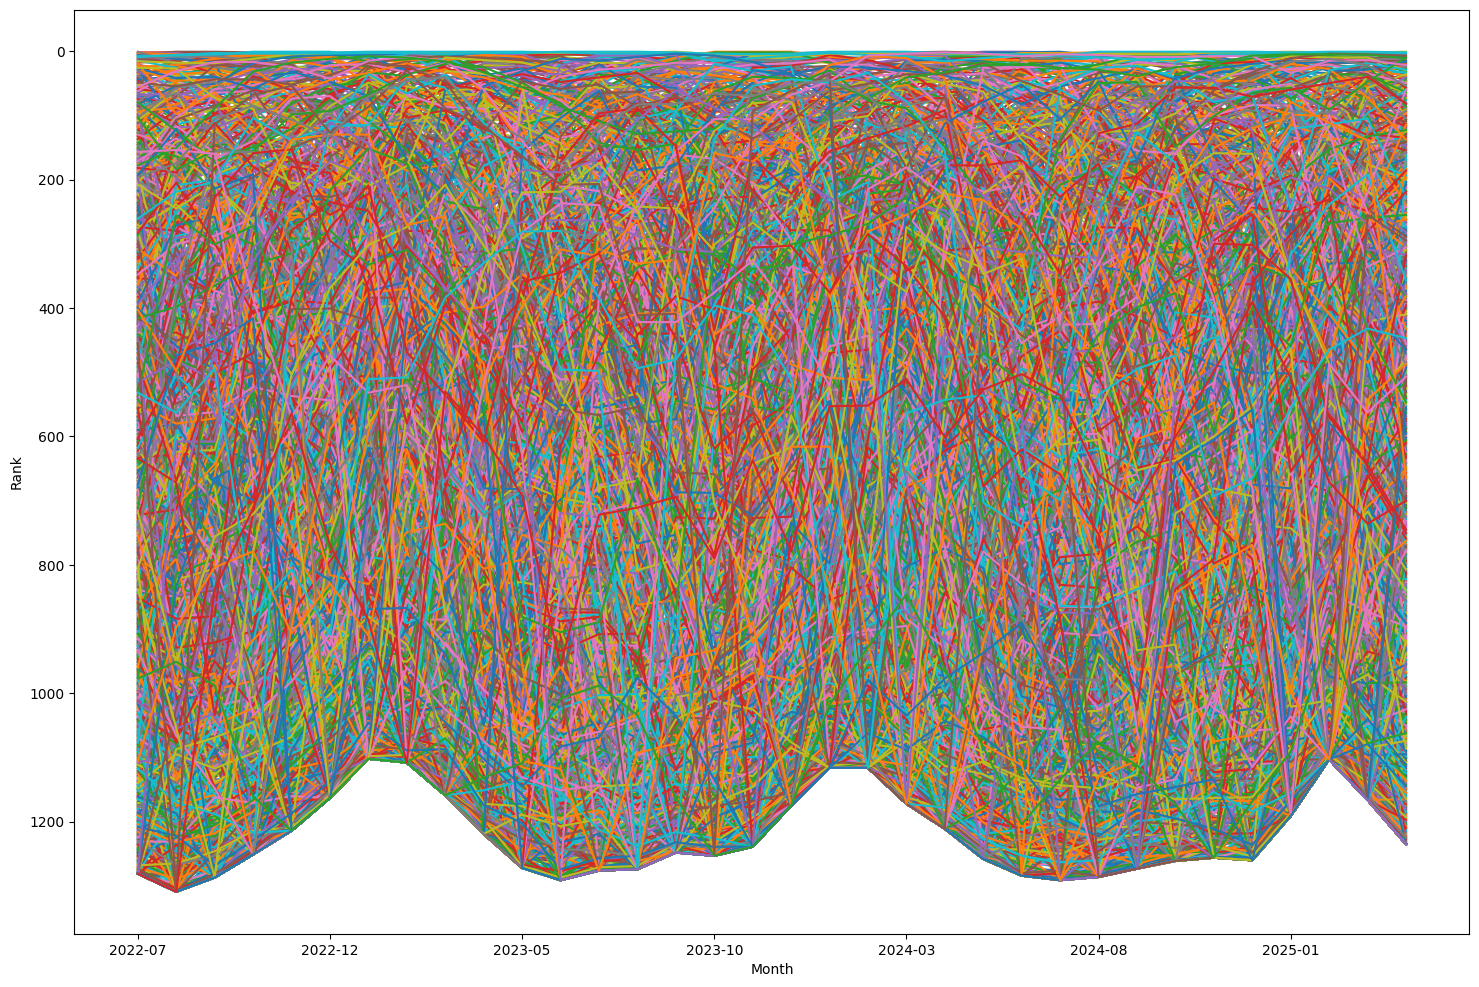

In [ ]:
# ranks based on rates
rate_ranks = smoothed_rates.apply(lambda col: col.rank(ascending=False))

ax = rate_ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

rate_ranks.sort_values(by=rate_ranks.columns[-1])

In [63]:
# compute month=-on-month stats
month_on_month = pd.DataFrame(index=pd.MultiIndex.from_tuples(pairwise(count_ranks.columns)))

month_on_month["Spearman rank correlation (count)"] = month_on_month.index.map(
    lambda idx: spearman_rank_correlation(count_ranks[list(idx)])
)
month_on_month["Spearman rank correlation (rate)"] = month_on_month.index.map(
    lambda idx: spearman_rank_correlation(rate_ranks[list(idx)])
)
month_on_month["Rank-biased overlap (count)"] = month_on_month.index.map(
    lambda idx: rank_biased_overlap(count_ranks[list(idx)])
)
month_on_month["Rank-biased overlap (rate)"] = month_on_month.index.map(
    lambda idx: rank_biased_overlap(rate_ranks[list(idx)])
)
month_on_month["Cosine similarity (count)"] = month_on_month.index.map(
    lambda idx: cosine_similarity(smoothed_counts[list(idx)])
)
month_on_month["Cosine similarity (rate)"] = month_on_month.index.map(
    lambda idx: cosine_similarity(smoothed_rates[list(idx)])
)

month_on_month

Spearman rank correlation (count)  \
2022-07 2022-08                           0.876556   
2022-08 2022-09                           0.894841   
2022-09 2022-10                           0.868741   
2022-10 2022-11                           0.869522   
2022-11 2022-12                           0.883316   
2022-12 2023-01                           0.788335   
2023-01 2023-02                           0.797778   
2023-02 2023-03                           0.858478   
2023-03 2023-04                           0.834275   
2023-04 2023-05                           0.852105   
2023-05 2023-06                           0.890355   
2023-06 2023-07                           0.884283   
2023-07 2023-08                           0.870956   
2023-08 2023-09                           0.878150   
2023-09 2023-10                           0.861073   
2023-10 2023-11                           0.880871   
2023-11 2023-12                           0.879213   
2023-12 2024-01                           0.829534   
2024-01 2024-02                           0.800819   
2024-02 2024-03                           0.840745   
2024-03 2024-04                           0.853298   
2024-04 2024-05                           0.847255   
2024-05 2024-06                           0.886467   
2024-06 2024-07                           0.888724   
2024-07 2024-08                           0.870178   
2024-08 2024-09                           0.882273   
2024-09 2024-10                           0.848287   
2024-10 2024-11                           0.857988   
2024-11 2024-12                           0.883777   
2024-12 2025-01                           0.835025   
2025-01 2025-02                           0.821780   
2025-02 2025-03                           0.804995   
2025-03 2025-04                           0.827624   

                 Spearman rank correlation (rate)  \
2022-07 2022-08                          0.927447   
2022-08 2022-09                          0.936182   
2022-09 2022-10                          0.921363   
2022-10 2022-11                          0.917259   
2022-11 2022-12                          0.932611   
2022-12 2023-01                          0.871528   
2023-01 2023-02                          0.868978   
2023-02 2023-03                          0.894911   
2023-03 2023-04                          0.889737   
2023-04 2023-05                          0.888452   
2023-05 2023-06                          0.923728   
2023-06 2023-07                          0.922475   
2023-07 2023-08                          0.917135   
2023-08 2023-09                          0.922677   
2023-09 2023-10                          0.915315   
2023-10 2023-11                          0.923803   
2023-11 2023-12                          0.922712   
2023-12 2024-01                          0.891660   
2024-01 2024-02                          0.871483   
2024-02 2024-03                          0.892382   
2024-03 2024-04                          0.903721   
2024-04 2024-05                          0.895919   
2024-05 2024-06                          0.922457   
2024-06 2024-07                          0.929228   
2024-07 2024-08                          0.915957   
2024-08 2024-09                          0.927947   
2024-09 2024-10                          0.904172   
2024-10 2024-11                          0.903911   
2024-11 2024-12                          0.931716   
2024-12 2025-01                          0.884158   
2025-01 2025-02                          0.865326   
2025-02 2025-03                          0.859903   
2025-03 2025-04                          0.881119   

                 Rank-biased overlap (count)  Rank-biased overlap (rate)  \
2022-07 2022-08                     0.602258                    0.466120   
2022-08 2022-09                     0.558419                    0.610942   
2022-09 2022-10                     0.513043                    0.459219   
2022-10 2022-11                     0.690478                    0.730561 

In [64]:
def calc_stats(counts: pd.Series):
    total_areas = len(counts)
    full_lorenz = lorenz_curve(counts)
    gini, lorenz = calc_gini(counts)  # .sort_values().cumsum() / counts.sum()
    return pd.Series(
        data={
            "prop_zero": (counts == 0).mean(),
            "prop_threshold": (full_lorenz >= SAMPLE_FRACTION).sum() / total_areas,
            "gini": gini,
            "lorenz": lorenz.to_numpy(),
            # TODO list top x areas?
        },
        name=counts.name,
    )


stats = pd.concat([calc_stats(series) for _, series in smoothed_counts.items()], axis=1).T
stats

prop_zero prop_threshold      gini  \
2022-07  0.088319       0.180199  0.505907   
2022-08  0.068376       0.183761  0.499134   
2022-09  0.084046        0.17735  0.512664   
2022-10  0.109687       0.172365  0.524825   
2022-11   0.13604       0.160256  0.547113   
2022-12  0.172365        0.14886  0.567918   
2023-01  0.215812       0.141026  0.588623   
2023-02  0.211538        0.14245  0.587119   
2023-03  0.175214       0.154558  0.563645   
2023-04  0.132479       0.159544  0.544585   
2023-05  0.094729       0.166667  0.527767   
2023-06  0.081197       0.170228   0.51983   
2023-07   0.09188       0.171652  0.520396   
2023-08  0.093305       0.172365  0.518204   
2023-09  0.111823        0.17094  0.521086   
2023-10  0.108262       0.170228   0.52385   
2023-11  0.118234       0.158832  0.544565   
2023-12  0.163818       0.148148  0.571035   
2024-01   0.20584       0.143162  0.581401   
2024-02   0.20584        0.14245  0.581566   
2024-03  0.165954        0.14886  0.565465   
2024-04  0.138177       0.159544  0.547192   
2024-05  0.104701       0.166667  0.528389   
2024-06  0.086182       0.176638  0.513951   
2024-07  0.081197       0.178775   0.50593   
2024-08  0.084758       0.180199  0.504923   
2024-09  0.094017       0.176638  0.512928   
2024-10  0.102564       0.173789  0.518973   
2024-11  0.106125       0.161681  0.534672   
2024-12  0.103276       0.154558   0.54287   
2025-01  0.152422       0.139601  0.573217   
2025-02    0.2151       0.123932  0.609606   
2025-03  0.170228       0.135328  0.583574   
2025-04  0.121083       0.153134  0.548824   

                                                    lorenz  
2022-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00035877...  
2022-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

/tmp/ipykernel_25394/3876859836.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spatial_units.join(rates.sum(axis=1).rename("density")).fillna(0).plot(


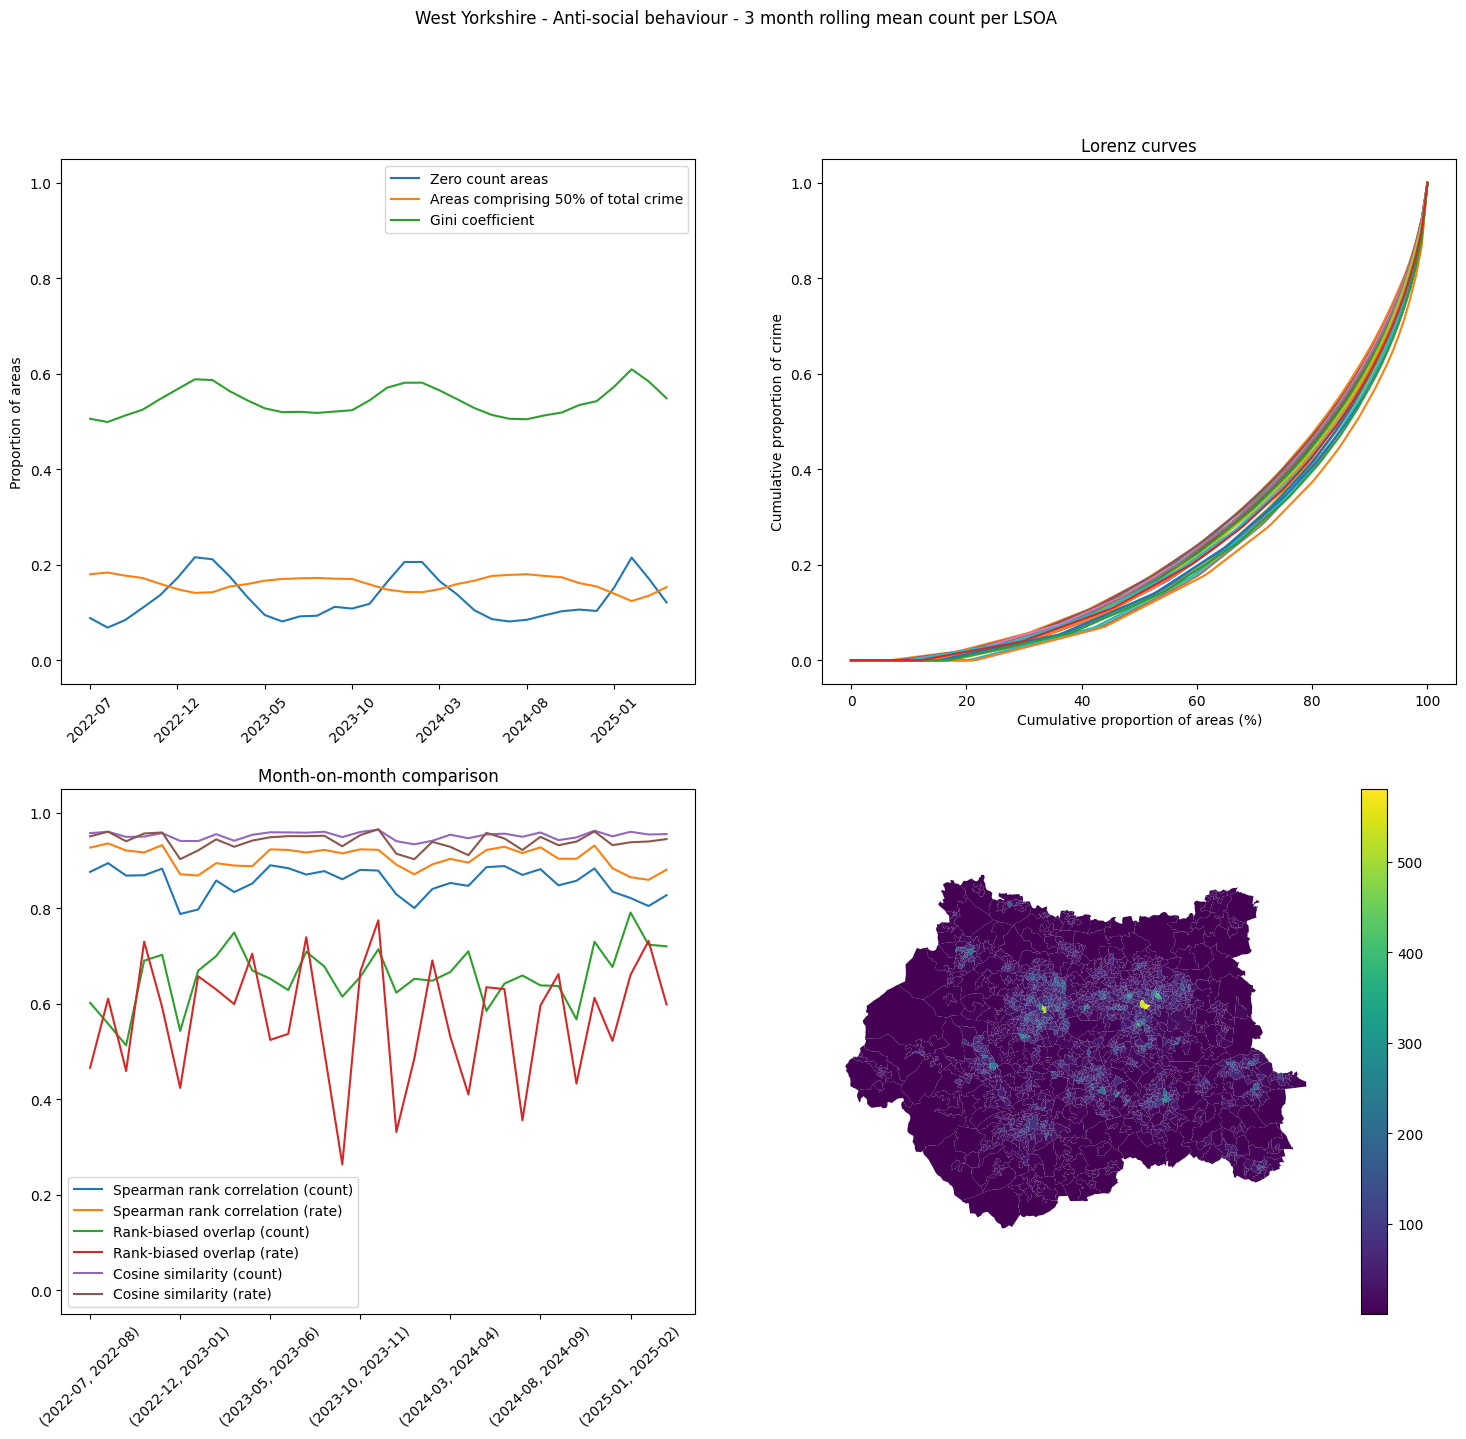

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle(f"{FORCE} - {CATEGORY} - {OBSERVATION_WINDOW} month rolling mean count per {AREA}")
# plt.tight_layout()
stats.prop_zero.plot(ax=axs[0, 0], label="Zero count areas")
stats.prop_threshold.plot(ax=axs[0, 0], label=f"Areas comprising {SAMPLE_FRACTION:.0%} of total crime")
stats.gini.plot(ax=axs[0, 0], label="Gini coefficient")
axs[0, 0].tick_params(axis="x", rotation=45)
axs[0, 0].set_ylabel("Proportion of areas")
axs[0, 0].set_ylim((-0.05, 1.05))
axs[0, 0].legend()

for name, row in stats.iterrows():
    axs[0, 1].plot(range(101), row["lorenz"], label=f"{name}")
axs[0, 1].set_xlabel("Cumulative proportion of areas (%)")
axs[0, 1].set_ylabel("Cumulative proportion of crime")
axs[0, 1].set_title("Lorenz curves")

month_on_month.plot(ax=axs[1, 0])
axs[1, 0].set_title("Month-on-month comparison")
axs[1, 0].tick_params(axis="x", rotation=45)
axs[1, 0].set_ylim((-0.05, 1.05))

if AREA != "STREET":
    spatial_units.join(rates.sum(axis=1).rename("density")).fillna(0).plot(
        ax=axs[1, 1], column="density", alpha=1, legend=True
    )
axs[1, 1].set_axis_off()